# Clustering a più dimensioni e euristica di miglioramento locale con centroidi

### Recupero delle istanze

In [24]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import time

from itertools import cycle, islice
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler


#Salvo i samples in delle liste di vettori
file = open("dim3.txt")
line = file.readlines()
n_samples = len(line)
n_features = len(line[0].split())
X= np.zeros((n_samples,n_features))

for i in range(n_samples):
    row = line[i].split()
    for j in range(n_features):
        X[i,j]= int(row[j]) 

print(X)



[[      0.  590860.  619423.]
 [   3979.  595698.  611132.]
 [   4433.  596095.  612479.]
 ...
 [ 995623.  974069.  641624.]
 [ 995757.  986464.  647034.]
 [1000000.  976042.  644851.]]


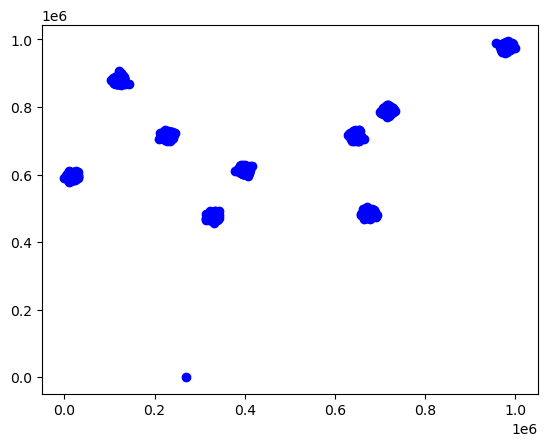

In [25]:
#Disegno l'istanza (Ha senso solo se ci sono solo 2 features)
plt.scatter(X[:, 0], X[:, 1], c= "blue" )

### Creo il modello

In [26]:
#Inizializzazione dell'algoritmo risolutore con K-means 
#Scelgo questi parametri affinche l'algoritmo mi dia una soluzione non buona
#Features = 5 -> random_states = 2
#Features = 2 -> random_states = 1
#Features = 3 -> random_states = 4


n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters,init = "random",random_state= 4, n_init=1)
kmeans

KMeans(init='random', n_clusters=9, n_init=1, random_state=4)

### Clustering con k-means con starting random

In [27]:
#Risolvo il problema sull'istanza X e mi salvo il vetore predittivo dei cluster in y_pred
kmeans.fit(X)
y_pred= kmeans.predict(X)

print(y_pred)


[3 3 3 ... 8 8 8]


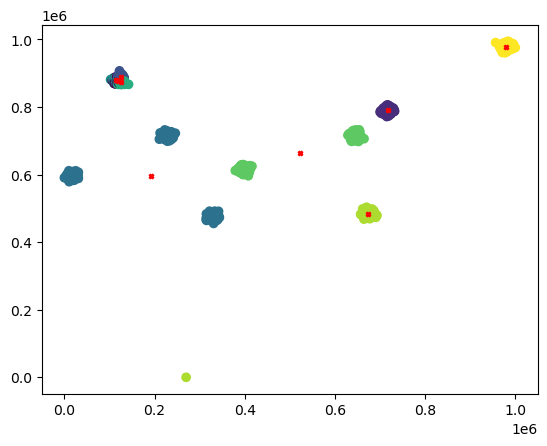

In [28]:
#Disegno la soluzione evidenziando i centroidi trovati (Ha senso solo per features = 2)
plt.scatter(X[:, 0], X[:, 1], c= y_pred )
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c='red', marker='X' )

In [29]:
#Funzione per calcolare la funzione obbiettivo totale
def obj_tot(n_samples,n_features,y_pred,X):
    opt = 0
    for k in range(n_samples):
        for h in range(k, n_samples):      #faccio partire da k per nn far contare due volte la stessa distanza 
            if y_pred[k] == y_pred[h]:     #Calcolo la distanza solo se i due nodi appartengono allo stesso cluster 
                sum = 0
                for f in range(n_features):
                    sum = sum +(X[h,f]-X[k,f])**2
                dist = np.sqrt(sum)    
                opt = opt + dist
    return opt
tot = obj_tot(n_samples,n_features,y_pred,X)

print(tot)


75365753555.80762


## Algoritmo di euristica migliorativa locale 

### Cambio i centroidi calcolati dall'algoritmo risolutore K-means 

In [30]:
kmeans.cluster_centers_

array([[119195.5       , 878506.90322581, 237630.93548387],
       [717385.50666667, 790734.79111111, 485051.66666667],
       [125070.94736842, 887837.54385965, 232783.26315789],
       [191426.72296296, 595910.38962963, 505353.09037037],
       [115156.91666667, 880482.72916667, 226857.5625    ],
       [126344.68965517, 875076.06896552, 230511.82758621],
       [521947.16222222, 663617.37333333, 911825.19333333],
       [672810.3761062 , 482472.87610619, 285955.45132743],
       [980087.93333333, 978866.66222222, 636380.75555556]])

In [31]:
#Calcolo punto medio per ogni coppia di centroidi 
def p_medio(p1,p2,n_features):
    p_medio = np.zeros(n_features)
    for i in range(n_features):
        punto_medio= (p1[i]+p2[i])/2
        p_medio[i] = punto_medio 

    return p_medio

In [32]:
#Creo un dizionario per salvarmi tutti i punti medi per coppia di centroidi

coppie_med ={}
 
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:

            P_med= p_medio(kmeans.cluster_centers_[i],kmeans.cluster_centers_[j],n_features)
            coppie_med[i,j] = P_med
            
              
print(coppie_med)

{(0, 1): array([418290.50333333, 834620.84716846, 361341.30107527]), (0, 2): array([122133.22368421, 883172.22354273, 235207.09932088]), (0, 3): array([155311.11148148, 737208.64642772, 371492.01292712]), (0, 4): array([117176.20833333, 879494.81619624, 232244.24899194]), (0, 5): array([122770.09482759, 876791.48609566, 234071.38153504]), (0, 6): array([320571.33111111, 771062.13827957, 574728.0644086 ]), (0, 7): array([396002.9380531 , 680489.889666  , 261793.19340565]), (0, 8): array([549641.71666667, 928686.78272401, 437005.84551971]), (1, 0): array([418290.50333333, 834620.84716846, 361341.30107527]), (1, 2): array([421228.22701754, 839286.16748538, 358917.46491228]), (1, 3): array([454406.11481482, 693322.59037037, 495202.37851852]), (1, 4): array([416271.21166667, 835608.76013889, 355954.61458333]), (1, 5): array([421865.09816092, 832905.43003831, 357781.74712644]), (1, 6): array([619666.33444444, 727176.08222222, 698438.43      ]), (1, 7): array([695097.94138643, 636603.83360865

### cerco di migliorare la funzione obbiettivo delle singole coppie di cluster 

In [33]:

#Funzione di ricalcolo del clustering   
def eur_locale(n_samples,n_clusters,new_centers,n_features,X):
    new_pred = np.zeros(n_samples)       #Definisco un nuovo vettore di clustering 
    for i in range(n_samples):
        list_dist = []
        for j in range(n_clusters):
            sum = 0
            for f in range(n_features):
                sum = sum +(X[i,f]-new_centers[j,f])**2  
            dist = np.sqrt(sum)
            list_dist.append(dist)              #Verifico la distanza di tutti i punti dai nuovi centroidi e costruisco il nuovo clustering 
        lower=min(list_dist)
        ind_min= list_dist.index(lower)
        new_pred[i]=ind_min
        
    return new_pred
            
    

### Applicazione dell'euristica di ricerca locale

In [34]:



new_centers = kmeans.cluster_centers_.copy()
new_obj = tot
new_clust = np.zeros(n_samples)
for k in range(n_clusters):
    for h in range(n_clusters): 
        if k != h:
            temp_centers = new_centers.copy()
            temp_centers[k]= coppie_med[k,h]
            
            new_temp = eur_locale(n_samples,n_clusters,temp_centers,n_features,X)
            obj_temp=obj_tot(n_samples,n_features,new_temp,X)
            print(obj_temp, " ", new_obj)
            
            if obj_temp< new_obj:
                new_obj = obj_temp
                new_centers[k] = temp_centers[k]
                new_clust = new_temp
            
print(new_obj)        
            
    
    

75393246612.53804   75365753555.80762
75368049269.271   75365753555.80762
75393246612.53804   75365753555.80762
75368266155.82964   75365753555.80762
75366803135.97685   75365753555.80762
41071781017.067764   75365753555.80762
29613223343.269253   41071781017.067764
75393246612.53804   29613223343.269253
29613223343.269253   29613223343.269253
29613223343.269253   29613223343.269253
29613223343.269253   29613223343.269253
29759464387.154346   29613223343.269253
29613223343.269253   29613223343.269253
29613223343.269253   29613223343.269253
29613223343.269253   29613223343.269253
29613223343.269253   29613223343.269253
29618504107.06278   29613223343.269253
29682161386.036854   29613223343.269253
29682161386.036854   29613223343.269253
29619755122.50839   29613223343.269253
29620324241.912777   29613223343.269253
17347406431.414875   29613223343.269253
29682161386.036854   17347406431.414875
29682161386.036854   17347406431.414875
17347406431.414875   17347406431.414875
29682161386.0368

In [35]:
new_centers

array([[396002.9380531 , 680489.889666  , 261793.19340565],
       [717385.50666667, 790734.79111111, 485051.66666667],
       [323509.05479532, 775727.45859649, 572304.22824561],
       [191426.72296296, 595910.38962963, 505353.09037037],
       [115156.91666667, 880482.72916667, 226857.5625    ],
       [126344.68965517, 875076.06896552, 230511.82758621],
       [521947.16222222, 663617.37333333, 911825.19333333],
       [695097.94138643, 636603.83360865, 385503.55899705],
       [980087.93333333, 978866.66222222, 636380.75555556]])

### Disegno la nuova soluzione

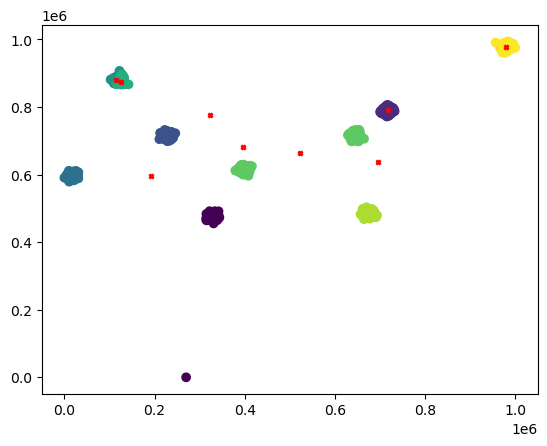

In [36]:


plt.scatter(X[:, 0], X[:, 1], c= new_clust )
plt.scatter(new_centers[:, 0], new_centers[:, 1], s=10, c='red', marker='X' )


    

## Testing su altri tipi di datasets


In [37]:
n_features = 2
n_samples = 1500
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=170
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=170)[0]
rng = np.random.RandomState(170)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170
)

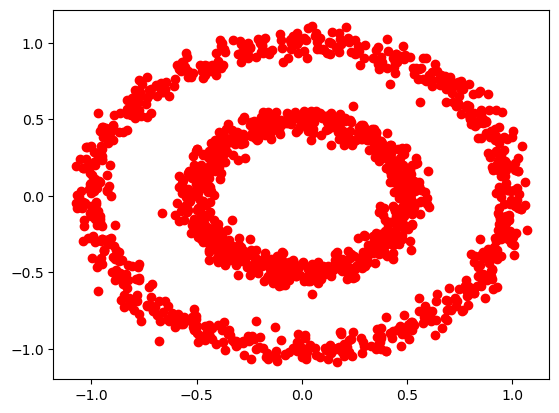

In [38]:
plt.scatter(noisy_circles[0][:, 0],noisy_circles[0][:, 1] , c= "red")

In [39]:
n_clusters = 9
kmeans_moon = KMeans(n_clusters=n_clusters,init = "random",random_state= 1, n_init=1)
kmeans_moon

KMeans(init='random', n_clusters=9, n_init=1, random_state=1)

In [40]:
kmeans_moon.fit(noisy_circles[0])
y_pred_circles= kmeans_moon.predict(noisy_circles[0])

print(y_pred_circles)


[6 0 7 ... 3 6 2]


C:\Users\alega\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


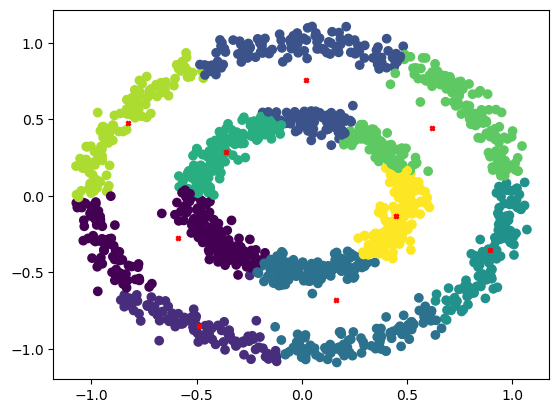

In [41]:
plt.scatter(noisy_circles[0][:, 0],noisy_circles[0][:, 1] , c= y_pred_circles)
plt.scatter(kmeans_moon.cluster_centers_[:, 0], kmeans_moon.cluster_centers_[:, 1], s=10, c='red', marker='X' )

In [42]:
tot = obj_tot(n_samples,2,y_pred_circles,noisy_circles[0])

print(tot)

48193.4854052025


In [43]:
coppie_med ={}
 
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:

            P_med= p_medio(kmeans_moon.cluster_centers_[i],kmeans_moon.cluster_centers_[j],n_features)
            coppie_med[i,j] = P_med
            
              
print(coppie_med)

{(0, 1): array([-0.5382074 , -0.56475587]), (0, 2): array([-0.2834239 ,  0.24104503]), (0, 3): array([-0.21264025, -0.47811162]), (0, 4): array([ 0.15371945, -0.31654232]), (0, 5): array([-0.47417847,  0.00598749]), (0, 6): array([0.01496117, 0.08332093]), (0, 7): array([-0.70677976,  0.09813109]), (0, 8): array([-0.06934409, -0.20340513]), (1, 0): array([-0.5382074 , -0.56475587]), (1, 2): array([-0.23444894, -0.04605204]), (1, 3): array([-0.16366529, -0.7652087 ]), (1, 4): array([ 0.20269441, -0.6036394 ]), (1, 5): array([-0.42520351, -0.28110959]), (1, 6): array([ 0.06393613, -0.20377614]), (1, 7): array([-0.6578048 , -0.18896598]), (1, 8): array([-0.02036913, -0.4905022 ]), (2, 0): array([-0.2834239 ,  0.24104503]), (2, 1): array([-0.23444894, -0.04605204]), (2, 3): array([0.09111821, 0.04059221]), (2, 4): array([0.45747791, 0.20216151]), (2, 5): array([-0.17042001,  0.52469131]), (2, 6): array([0.31871963, 0.60202476]), (2, 7): array([-0.4030213 ,  0.61683492]), (2, 8): array([0.2

In [44]:
new_centers = kmeans_moon.cluster_centers_.copy()
new_obj = tot
new_clust = np.zeros(n_samples)
for k in range(n_clusters):
    for h in range(n_clusters): 
        if k != h:
            temp_centers = new_centers.copy()
            temp_centers[k]= coppie_med[k,h]
            
            new_temp = eur_locale(n_samples,n_clusters,temp_centers,2,noisy_circles[0])
            obj_temp=obj_tot(n_samples,2,new_temp,noisy_circles[0])
            print(obj_temp, " ", new_obj)
            
            if obj_temp< new_obj:
                new_obj = obj_temp
                new_centers[k] = temp_centers[k]
                new_clust = new_temp
            
print(new_obj)        
            

48142.76202966321   48193.4854052025
50730.279087018156   48142.76202966321
44626.31450109865   48142.76202966321
47439.620359199915   44626.31450109865
48392.53437601778   44626.31450109865
52593.26958745429   44626.31450109865
48740.36350834034   44626.31450109865
45159.93205525694   44626.31450109865
45390.5152323331   44626.31450109865
50496.664074550696   44626.31450109865
47088.38686748437   44626.31450109865
52402.36033485912   44626.31450109865
45936.89262826721   44626.31450109865
56252.07363746009   44626.31450109865
46139.681155663886   44626.31450109865
50201.51172820684   44626.31450109865
53519.1890471147   44626.31450109865
56360.30917937432   44626.31450109865
57945.453172867645   44626.31450109865
51441.378692399914   44626.31450109865
46031.845742401805   44626.31450109865
46251.3241070581   44626.31450109865
47718.61850119345   44626.31450109865
47034.99014016391   44626.31450109865
54817.13408009806   44626.31450109865
45025.66227543219   44626.31450109865
53374.841

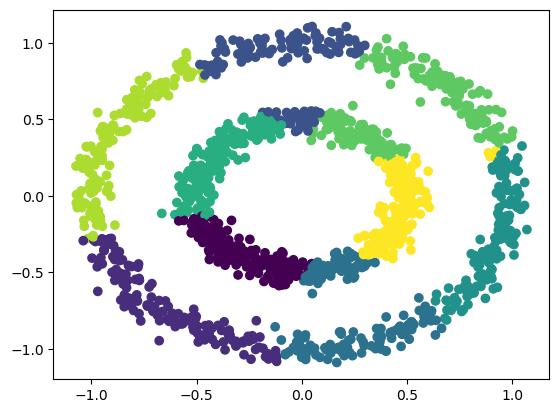

In [45]:
plt.scatter(noisy_circles[0][:, 0],noisy_circles[0][:, 1] , c= new_clust)


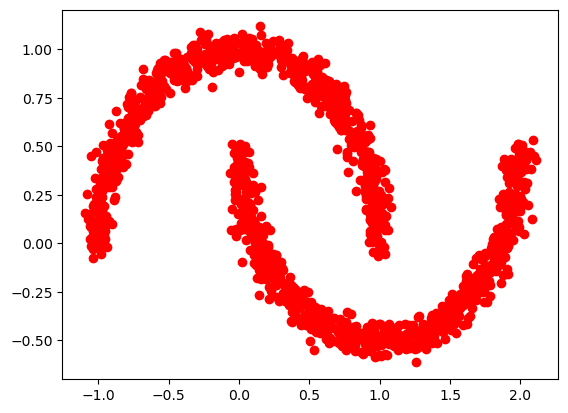

In [46]:
plt.scatter(noisy_moons[0][:, 0],noisy_moons[0][:, 1] , c= "red")

In [47]:
n_clusters = 9
kmeans_moons = KMeans(n_clusters=n_clusters,init = "random",random_state= 2, n_init=1)
kmeans_moons

KMeans(init='random', n_clusters=9, n_init=1, random_state=2)

In [48]:
kmeans_moons.fit(noisy_moons[0])
y_pred_moons= kmeans_moons.predict(noisy_moons[0])

print(y_pred_moons)


[3 1 8 ... 0 5 3]


C:\Users\alega\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


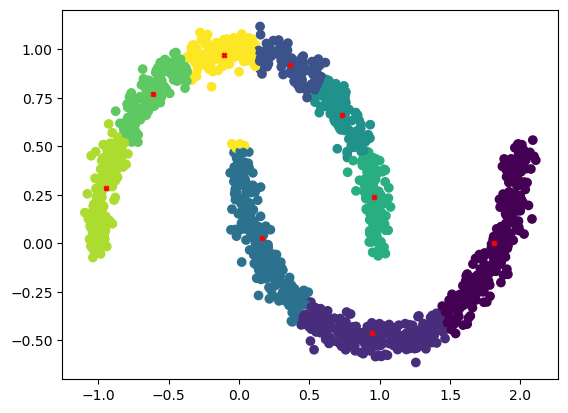

In [49]:
plt.scatter(noisy_moons[0][:, 0],noisy_moons[0][:, 1]  , c= y_pred_moons)
plt.scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1], s=10, c='red', marker='X' )

In [50]:
tot = obj_tot(n_samples,2,y_pred_moons,noisy_moons[0])

print(tot)  

42559.96113861862


In [51]:
coppie_med ={}
 
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:

            P_med= p_medio(kmeans_moons.cluster_centers_[i],kmeans_moons.cluster_centers_[j],n_features)
            coppie_med[i,j] = P_med
            
              
print(coppie_med)

{(0, 1): array([ 1.37963663, -0.22917353]), (0, 2): array([1.08864036, 0.46052659]), (0, 3): array([0.98660083, 0.01629691]), (0, 4): array([1.2730373 , 0.33324773]), (0, 5): array([1.38425316, 0.12201796]), (0, 6): array([0.60117388, 0.38686284]), (0, 7): array([0.43249466, 0.14400585]), (0, 8): array([0.85370022, 0.48588045]), (1, 0): array([ 1.37963663, -0.22917353]), (1, 2): array([0.65642765, 0.22742449]), (1, 3): array([ 0.55438812, -0.21680519]), (1, 4): array([0.84082458, 0.10014563]), (1, 5): array([ 0.95204044, -0.11108414]), (1, 6): array([0.16896116, 0.15376074]), (1, 7): array([ 0.00028194, -0.08909625]), (1, 8): array([0.4214875 , 0.25277834]), (2, 0): array([1.08864036, 0.46052659]), (2, 1): array([0.65642765, 0.22742449]), (2, 3): array([0.26339185, 0.47289493]), (2, 4): array([0.54982832, 0.78984575]), (2, 5): array([0.66104417, 0.57861598]), (2, 6): array([-0.12203511,  0.84346085]), (2, 7): array([-0.29071432,  0.60060387]), (2, 8): array([0.13049123, 0.94247846]), (

In [52]:
new_centers = kmeans_moons.cluster_centers_.copy()
new_obj = tot
new_clust = np.zeros(n_samples)
for k in range(n_clusters):
    for h in range(n_clusters): 
        if k != h:
            temp_centers = new_centers.copy()
            temp_centers[k]= coppie_med[k,h]
            
            new_temp = eur_locale(n_samples,n_clusters,temp_centers,2,noisy_moons[0])
            obj_temp=obj_tot(n_samples,2,new_temp,noisy_moons[0])
            print(obj_temp, " ", new_obj)
            
            if obj_temp< new_obj:
                new_obj = obj_temp
                new_centers[k] = temp_centers[k]
                new_clust = new_temp
            
print(new_obj)        

46674.425194812335   42559.96113861862
56112.01134235851   42559.96113861862
49042.787722905916   42559.96113861862
44147.00789320635   42559.96113861862
42564.720951327814   42559.96113861862
70639.54707004307   42559.96113861862
70313.20689649301   42559.96113861862
65438.29121241829   42559.96113861862
44688.34854520665   42559.96113861862
57900.17942374082   42559.96113861862
46877.488928812665   42559.96113861862
48519.51504563283   42559.96113861862
44076.090837564334   42559.96113861862
52511.18617144891   42559.96113861862
62644.46813027089   42559.96113861862
63150.838468100344   42559.96113861862
45502.61599113667   42559.96113861862
46489.356226178854   42559.96113861862
41886.46742460606   42559.96113861862
43009.36583035263   41886.46742460606
45255.5009569181   41886.46742460606
44106.1997135175   41886.46742460606
43729.682038382685   41886.46742460606
42752.387291682586   41886.46742460606
49201.94773546657   41886.46742460606
36552.89482099755   41886.46742460606
49905

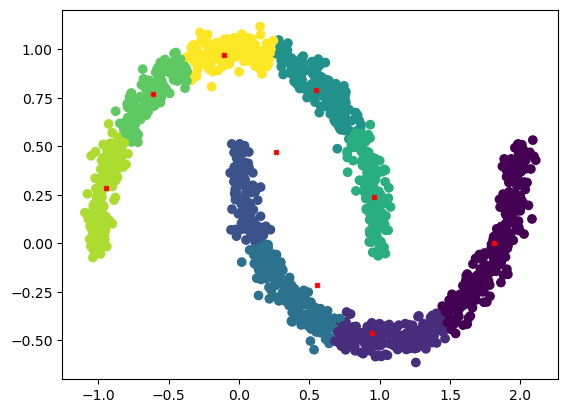

In [53]:
plt.scatter(noisy_moons[0][:, 0],noisy_moons[0][:, 1]  , c= new_clust)
plt.scatter(new_centers[:, 0], new_centers[:, 1], s=10, c='red', marker='X')

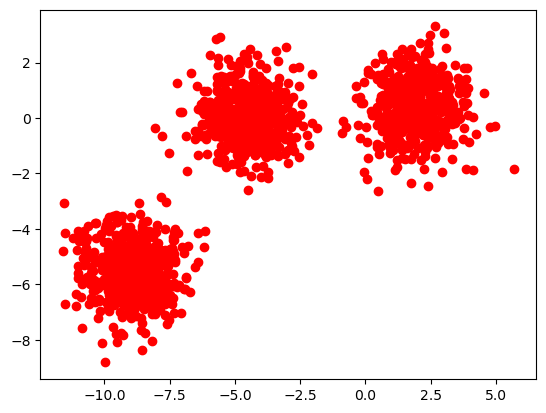

In [54]:
plt.scatter(blobs[:, 0],blobs[:, 1]  , c= 'red')

In [55]:
n_clusters = 9
kmeans_blob = KMeans(n_clusters=n_clusters,init = "random",random_state= 2, n_init=1)
kmeans_blob 

KMeans(init='random', n_clusters=9, n_init=1, random_state=2)

In [56]:
kmeans_blob.fit(blobs)
y_pred_blob= kmeans_blob.predict(blobs)

print(y_pred_blob)


[0 0 4 ... 1 6 1]


C:\Users\alega\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


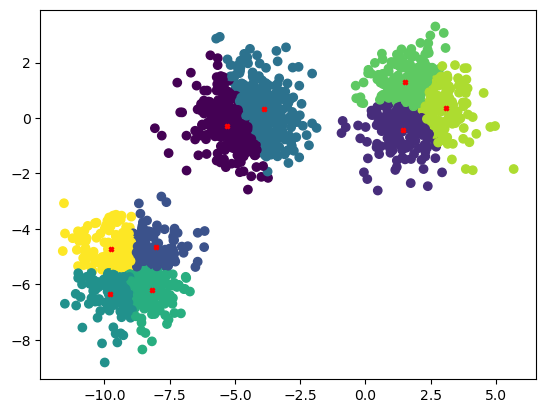

In [57]:
plt.scatter(blobs[:, 0],blobs[:, 1]  , c= y_pred_blob)
plt.scatter(kmeans_blob.cluster_centers_[:, 0], kmeans_blob.cluster_centers_[:, 1], s=10, c='red', marker='X')

In [58]:
tot = obj_tot(n_samples,2,y_pred_blob,blobs)

print(tot)

166296.64321834975


In [59]:
coppie_med ={}
 
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:

            P_med= p_medio(kmeans_blob.cluster_centers_[i],kmeans_blob.cluster_centers_[j],n_features)
            coppie_med[i,j] = P_med
            
              
print(coppie_med)

{(0, 1): array([-1.9336447 , -0.35241332]), (0, 2): array([-6.67044327, -2.47224674]), (0, 3): array([-4.59172565,  0.0137055 ]), (0, 4): array([-7.54228824, -3.31204159]), (0, 5): array([-6.74262656, -3.24183471]), (0, 6): array([-1.88916641,  0.50338493]), (0, 7): array([-1.10530004,  0.03751384]), (0, 8): array([-7.52171481, -2.50281452]), (1, 0): array([-1.9336447 , -0.35241332]), (1, 2): array([-3.30436762, -2.54022837]), (1, 3): array([-1.22565001, -0.05427613]), (1, 4): array([-4.17621259, -3.38002322]), (1, 5): array([-3.37655091, -3.30981634]), (1, 6): array([1.47690924, 0.4354033 ]), (1, 7): array([ 2.26077561, -0.0304678 ]), (1, 8): array([-4.15563916, -2.57079615]), (2, 0): array([-6.67044327, -2.47224674]), (2, 1): array([-3.30436762, -2.54022837]), (2, 3): array([-5.96244858, -2.17410955]), (2, 4): array([-8.91301116, -5.49985664]), (2, 5): array([-8.11334948, -5.42964976]), (2, 6): array([-3.25988933, -1.68443012]), (2, 7): array([-2.47602296, -2.15030122]), (2, 8): arra

In [60]:
new_centers = kmeans_blob.cluster_centers_.copy()
new_obj = tot
new_clust = np.zeros(n_samples)
for k in range(n_clusters):
    for h in range(n_clusters): 
        if k != h:
            temp_centers = new_centers.copy()
            temp_centers[k]= coppie_med[k,h]
            
            new_temp = eur_locale(n_samples,n_clusters,temp_centers,2,blobs)
            obj_temp=obj_tot(n_samples,2,new_temp,blobs)
            print(obj_temp, " ", new_obj)
            
            if obj_temp< new_obj:
                new_obj = obj_temp
                new_centers[k] = temp_centers[k]
                new_clust = new_temp
            
print(new_obj)        

258376.07985254502   166296.64321834975
253068.81237860548   166296.64321834975
174306.82068106157   166296.64321834975
277959.31738403515   166296.64321834975
271074.3457718685   166296.64321834975
261881.7238411025   166296.64321834975
273775.10521257645   166296.64321834975
267185.5850901075   166296.64321834975
186541.53214194582   166296.64321834975
193292.55088700034   166296.64321834975
185685.72280725845   166296.64321834975
201833.24091741935   166296.64321834975
199681.30007848796   166296.64321834975
169330.9528786396   166296.64321834975
171080.8612968426   166296.64321834975
194343.44837433557   166296.64321834975
178879.66290554169   166296.64321834975
175140.50318183063   166296.64321834975
175051.87240361952   166296.64321834975
168429.32801772386   166296.64321834975
167785.3045248975   166296.64321834975
163113.23655171454   166296.64321834975
173693.89582129946   163113.23655171454
167578.64414258685   163113.23655171454
167131.02167092127   163113.23655171454
211854

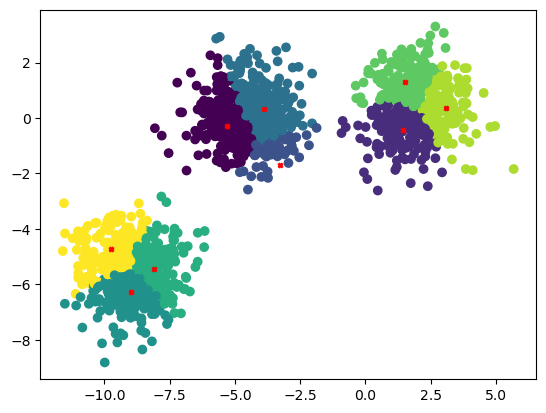

In [61]:
plt.scatter(blobs[:, 0],blobs[:, 1]  , c= new_clust)
plt.scatter(new_centers[:, 0], new_centers[:, 1], s=10, c='red', marker='X')

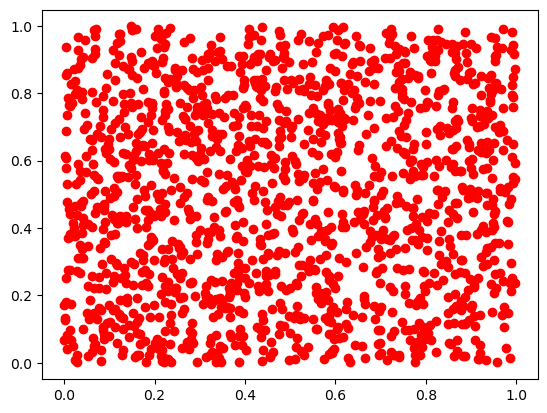

In [62]:
plt.scatter(no_structure[0][:, 0],no_structure[0][:, 1] , c= 'red')

In [63]:
n_clusters = 9
kmeans_rng = KMeans(n_clusters=n_clusters,init = "random",random_state= 2, n_init=1)
kmeans_rng 

KMeans(init='random', n_clusters=9, n_init=1, random_state=2)

In [64]:
kmeans_rng.fit(no_structure[0])
y_pred_rng= kmeans_rng.predict(no_structure[0])

print(y_pred_rng)


[0 7 1 ... 6 5 8]


C:\Users\alega\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


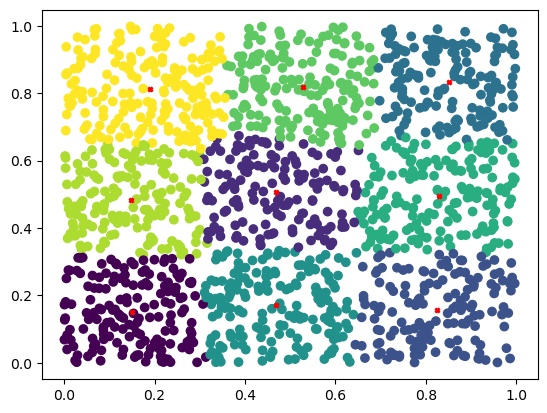

In [65]:
plt.scatter(no_structure[0][:, 0],no_structure[0][:, 1] , c= y_pred_rng)
plt.scatter(kmeans_rng.cluster_centers_[:, 0], kmeans_rng.cluster_centers_[:, 1], s=10, c='red', marker='X')

In [66]:
tot = obj_tot(n_samples,2,y_pred_rng,no_structure[0])

print(tot)

21423.583560768962


In [67]:
coppie_med ={}
 
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:

            P_med= p_medio(kmeans_rng.cluster_centers_[i],kmeans_rng.cluster_centers_[j],n_features)
            coppie_med[i,j] = P_med
            
              
print(coppie_med)

{(0, 1): array([0.30989728, 0.32953569]), (0, 2): array([0.48769108, 0.15401666]), (0, 3): array([0.50051797, 0.49299703]), (0, 4): array([0.30958572, 0.16087061]), (0, 5): array([0.48998852, 0.32380867]), (0, 6): array([0.33973433, 0.48526278]), (0, 7): array([0.14919739, 0.31789522]), (0, 8): array([0.16955796, 0.4813131 ]), (1, 0): array([0.30989728, 0.32953569]), (1, 2): array([0.6470134 , 0.33213409]), (1, 3): array([0.6598403 , 0.67111446]), (1, 4): array([0.46890804, 0.33898804]), (1, 5): array([0.64931085, 0.5019261 ]), (1, 6): array([0.49905665, 0.66338021]), (1, 7): array([0.30851972, 0.49601265]), (1, 8): array([0.32888029, 0.65943053]), (2, 0): array([0.48769108, 0.15401666]), (2, 1): array([0.6470134 , 0.33213409]), (2, 3): array([0.8376341 , 0.49559543]), (2, 4): array([0.64670185, 0.16346901]), (2, 5): array([0.82710465, 0.32640706]), (2, 6): array([0.67685045, 0.48786118]), (2, 7): array([0.48631352, 0.32049362]), (2, 8): array([0.50667409, 0.4839115 ]), (3, 0): array([

In [68]:
new_centers = kmeans_rng.cluster_centers_.copy()
new_obj = tot
new_clust = y_pred_rng
for k in range(n_clusters):
    for h in range(n_clusters): 
        if k != h:
            temp_centers = new_centers.copy()
            temp_centers[k]= coppie_med[k,h]
            
            new_temp = eur_locale(n_samples,n_clusters,temp_centers,2,no_structure[0])
            obj_temp=obj_tot(n_samples,2,new_temp,no_structure[0])
            print(obj_temp, " ", new_obj)
            
            if obj_temp< new_obj:
                new_obj = obj_temp
                new_centers[k] = temp_centers[k]
                new_clust = new_temp
            
print(new_obj)        

22526.798218589076   21423.583560768962
24377.581549635746   21423.583560768962
27605.76438076335   21423.583560768962
21923.324011871668   21423.583560768962
25369.230006046495   21423.583560768962
26421.10190647276   21423.583560768962
22129.585322337785   21423.583560768962
25439.533557265488   21423.583560768962
22590.839696349605   21423.583560768962
22374.546548137707   21423.583560768962
22698.62617589831   21423.583560768962
21876.378914060024   21423.583560768962
21952.80210536691   21423.583560768962
21926.693055887066   21423.583560768962
21948.62094484011   21423.583560768962
22012.06763527428   21423.583560768962
24023.309648840885   21423.583560768962
22504.095210093757   21423.583560768962
24646.073170562537   21423.583560768962
22065.952738742883   21423.583560768962
21957.844186093334   21423.583560768962
25324.04796622059   21423.583560768962
25569.416589029646   21423.583560768962
27303.6980743353   21423.583560768962
27051.758635588   21423.583560768962
22509.590755

### Euristica migliorativa che cambia i centroidi non migliora la soluzione 

In [69]:
new_clust

array([0, 7, 1, ..., 6, 5, 8])

### Nuova euristica migliorativa per istanze di cluser senza struttura 

In [70]:
    dist_dic = {}
    dist_vec = []
    for j in range(n_clusters):
        for i in range(n_samples):
            sum = 0
            for f in range(n_features):
                sum = sum + ((no_structure[0][i][f] - kmeans_rng.cluster_centers_[j][f])**2)
            dist = np.sqrt(sum)
            dist_dic[dist] = [i,j]
            dist_vec.append(dist)

                          

In [71]:
cont = 0
temp_obj = new_obj
cluster_opt = new_clust.copy()
for k in range(10000):
    if cont > 50:
        break
    
    min_dist = min(dist_vec)
    coppia = dist_dic[min_dist]
    temp_clust = cluster_opt.copy()
    #print(coppia[1], " ", new_clust[coppia[0]])
    if coppia[1] != cluster_opt[coppia[0]]:
        #print("ok")
        temp_clust[coppia[0]] = coppia[1]
        temp_obj = obj_tot(n_samples,2,temp_clust,no_structure[0])
        if temp_obj < new_obj: 
            new_obj = temp_obj
            cont = 0
            cluster_opt = temp_clust
            print("entrato")
            
            
        else:
            cont = cont +1
            print("non entrato")
        
        print ( temp_obj, " ", new_obj) 
        print (cont)
        
    dist_vec.remove(min_dist)
       
        
        



entrato
21418.512930924295   21418.512930924295
0
non entrato
21423.0810973337   21418.512930924295
1
non entrato
21424.87614825984   21418.512930924295
2
non entrato
21426.03501714266   21418.512930924295
3
entrato
21415.18427051719   21415.18427051719
0
entrato
21412.144103073075   21412.144103073075
0
entrato
21405.51995032342   21405.51995032342
0
non entrato
21410.594998034016   21405.51995032342
1
non entrato
21413.860229150177   21405.51995032342
2
entrato
21403.263787680495   21403.263787680495
0
entrato
21400.210438945804   21400.210438945804
0
non entrato
21406.7825029238   21400.210438945804
1
non entrato
21409.121125250025   21400.210438945804
2
non entrato
21404.886460095724   21400.210438945804
3
entrato
21397.284740740335   21397.284740740335
0
non entrato
21397.95679336861   21397.284740740335
1
non entrato
21403.117484115683   21397.284740740335
2
entrato
21394.152482422312   21394.152482422312
0
non entrato
21399.689796676226   21394.152482422312
1
entrato
21388.92539

In [72]:
cluster_opt

array([0, 7, 1, ..., 6, 5, 8])

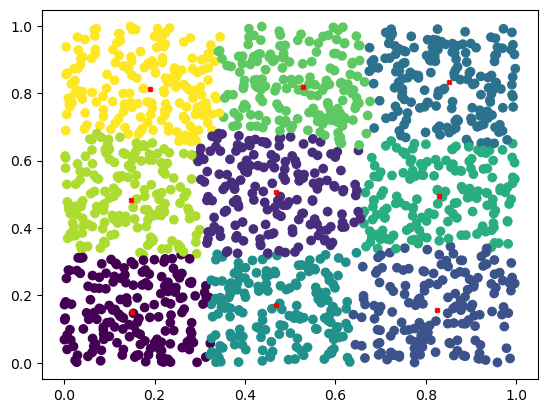

In [73]:
plt.scatter(no_structure[0][:, 0],no_structure[0][:, 1] , c= cluster_opt)
plt.scatter(kmeans_rng.cluster_centers_[:, 0], kmeans_rng.cluster_centers_[:, 1], s=10, c='red', marker='X')

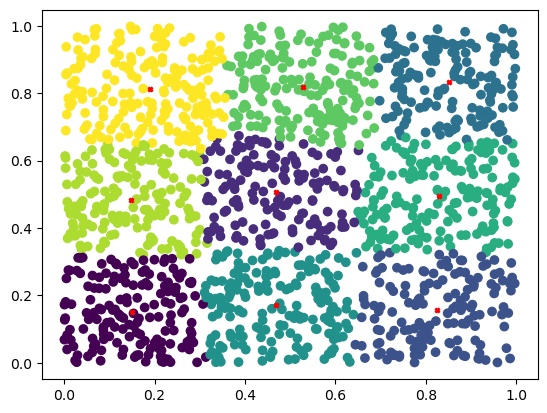

In [74]:
plt.scatter(no_structure[0][:, 0],no_structure[0][:, 1] , c= y_pred_rng)
plt.scatter(kmeans_rng.cluster_centers_[:, 0], kmeans_rng.cluster_centers_[:, 1], s=10, c='red', marker='X')

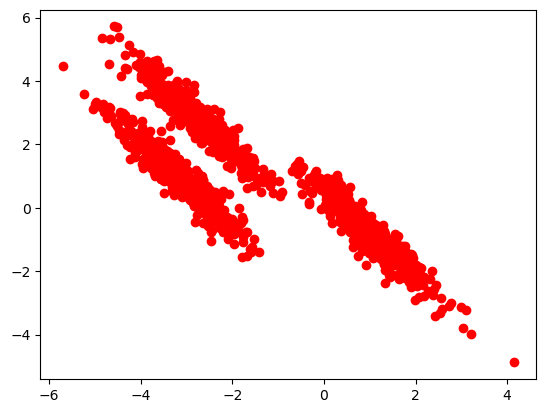

In [75]:
plt.scatter(aniso[0][:, 0],aniso[0][:, 1] , c= 'red')

In [76]:
n_clusters = 9
kmeans_aniso = KMeans(n_clusters=n_clusters,init = "random",random_state= 2, n_init=1)
kmeans_aniso

KMeans(init='random', n_clusters=9, n_init=1, random_state=2)

In [77]:
kmeans_aniso.fit(aniso[0])
y_pred_aniso= kmeans_aniso.predict(aniso[0])

print(y_pred_aniso)

[0 0 4 ... 1 6 1]


C:\Users\alega\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


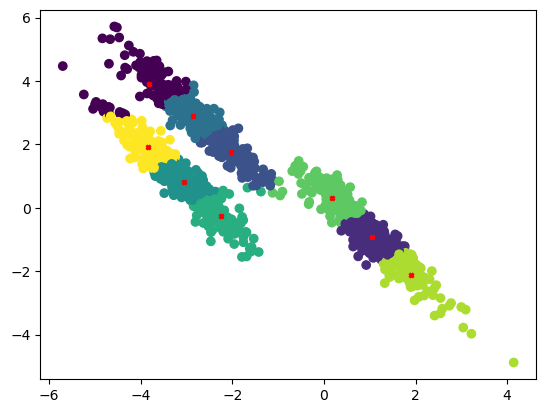

In [78]:
plt.scatter(aniso[0][:, 0],aniso[0][:, 1] , c= y_pred_aniso)
plt.scatter(kmeans_aniso.cluster_centers_[:, 0], kmeans_aniso.cluster_centers_[:, 1], s=10, c='red', marker='X')

In [79]:
tot = obj_tot(n_samples,2,y_pred_aniso,aniso[0])

print(tot)

82898.7596835199


In [80]:
coppie_med ={}
 
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:

            P_med= p_medio(kmeans_aniso.cluster_centers_[i],kmeans_aniso.cluster_centers_[j],n_features)
            coppie_med[i,j] = P_med
            
              
print(coppie_med)

{(0, 1): array([-1.38919742,  1.49731442]), (0, 2): array([-2.92890662,  2.84641464]), (0, 3): array([-3.33636651,  3.41538415]), (0, 4): array([-3.43883511,  2.37183566]), (0, 5): array([-3.0393038 ,  1.82520372]), (0, 6): array([-1.8233059 ,  2.11359267]), (0, 7): array([-0.96146789,  0.9052521 ]), (0, 8): array([-3.83360617,  2.91639523]), (1, 0): array([-1.38919742,  1.49731442]), (1, 2): array([-0.49398086,  0.42219884]), (1, 3): array([-0.90144074,  0.99116835]), (1, 4): array([-1.00390934, -0.05238014]), (1, 5): array([-0.60437803, -0.59901208]), (1, 6): array([ 0.61161986, -0.31062313]), (1, 7): array([ 1.47345788, -1.5189637 ]), (1, 8): array([-1.39868041,  0.49217943]), (2, 0): array([-2.92890662,  2.84641464]), (2, 1): array([-0.49398086,  0.42219884]), (2, 3): array([-2.44114995,  2.34026857]), (2, 4): array([-2.54361854,  1.29672008]), (2, 5): array([-2.14408723,  0.75008814]), (2, 6): array([-0.92808934,  1.03847709]), (2, 7): array([-0.06625132, -0.16986348]), (2, 8): ar

In [81]:
new_centers = kmeans_aniso.cluster_centers_.copy()
new_obj = tot
new_clust = np.zeros(n_samples)
for k in range(n_clusters):
    for h in range(n_clusters): 
        if k != h:
            temp_centers = new_centers.copy()
            temp_centers[k]= coppie_med[k,h]
            
            new_temp = eur_locale(n_samples,n_clusters,temp_centers,2,aniso[0])
            obj_temp=obj_tot(n_samples,2,new_temp,aniso[0])
            print(obj_temp, " ", new_obj)
            
            if obj_temp< new_obj:
                new_obj = obj_temp
                new_centers[k] = temp_centers[k]
                new_clust = new_temp
            
print(new_obj)        

111872.21873966524   82898.7596835199
93376.49138177911   82898.7596835199
83223.51621132118   82898.7596835199
112868.58681989364   82898.7596835199
111812.89995442054   82898.7596835199
113527.94589823633   82898.7596835199
112328.94436746484   82898.7596835199
84682.717035311   82898.7596835199
98820.50163947811   82898.7596835199
95373.90886784659   82898.7596835199
97314.05460166969   82898.7596835199
105112.56146605546   82898.7596835199
106125.4285477504   82898.7596835199
82986.14083669716   82898.7596835199
87134.91379448847   82898.7596835199
100738.48288376619   82898.7596835199
99750.75617788607   82898.7596835199
108702.37065198501   82898.7596835199
83532.59151181526   82898.7596835199
85670.84785349826   82898.7596835199
92711.3049822045   82898.7596835199
97527.45973238246   82898.7596835199
114190.7723835842   82898.7596835199
85460.90351886713   82898.7596835199
86517.4675482518   82898.7596835199
99517.09938051047   82898.7596835199
85147.98594105225   82898.75968351

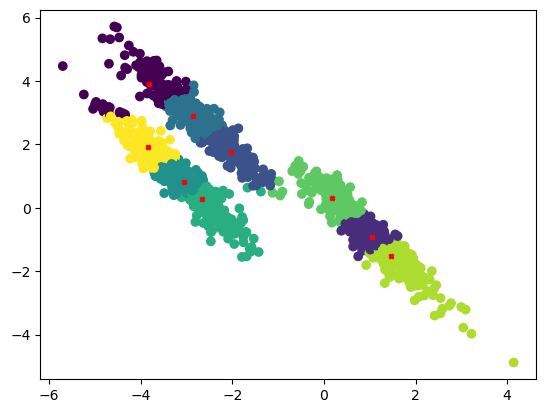

In [82]:
plt.scatter(aniso[0][:, 0],aniso[0][:, 1] , c= new_clust)
plt.scatter(new_centers[:, 0], new_centers[:, 1], s=10, c='red', marker='X')